In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Linear Regression

This notebook is inspired by a lecture and assignment on Linear Regression taken within MSc course.

Regression is used when we have noisy observations i.e. n, d - dimensional, inputs:
$\bold{x}_{1:n} = [\bold{x}_{1}, \cdots, \bold{x}_{n}]$, with corresponding outputs: 
$\bold{y}_{1:n} = [y_{1}, \cdots, y_{n}]$.

Regression is used to find the map between the inputs and the outputs.

Linear regression is the simplest approach.

The general linearised model (GLM) is given by:
$$
y(x; w) = \sum_{j=1}^{m} w_j \phi_j(x) = \mathbf{w}^T \phi(x)
$$
where $\bold{w} = (w_{1}, \cdots, w_{m})^{T}$ are the weights and 
$\bold{\phi} = (\phi_1, \cdots, \phi_m)^T$ are arbitrary basis functions. 

The GLM is linear in $\bold{w}$, the basis functions, $\bold{\phi}(\bold{x})$ can be non-linear whilst the regression model is still linear. 

Examples of basis functions include:
 - linear, 
 - polynomial,
 - radial basis functions (RBF),
 - Fourier series


## Least squares

The best values of the weights $\bold{w}$ can be found using least squares regression, (minimising a quadratic loss function):

$$
\mathbf{w}_{\text{LS}} = \left( \Phi^T \Phi \right)^{-1} \Phi^T \mathbf{y}_{1:n}
$$

Where $\Phi$ is a n*m design matrix stemming from the evaluation of each basis function $\phi_j$ on each datapoint $\bold{x}_i$.

In practise $\Phi^T \Phi$ is not explicitly calculated due to unstability of matrix inversions, instead the QR decomposition is calculated. 
This is done within libraries such as numpyp.linalg.lstsq.

Application to generated example datasets:

In [2]:
#generating example functions
a_0 = -0.3
a_1 = 0.5

def noise(size, variance):
    return np.random.normal(scale=np.sqrt(variance), size=size)

def f(X, noise_variance):
    """
    Linear function plus noise
    """
    return a_0 + a_1*X + noise(X.shape, noise_variance)


def g(X, noise_variance):
    """
    Sinus function plus noise
    """
    return 0.5 + np.sin(2*np.pi*X) + noise(X.shape, noise_variance)

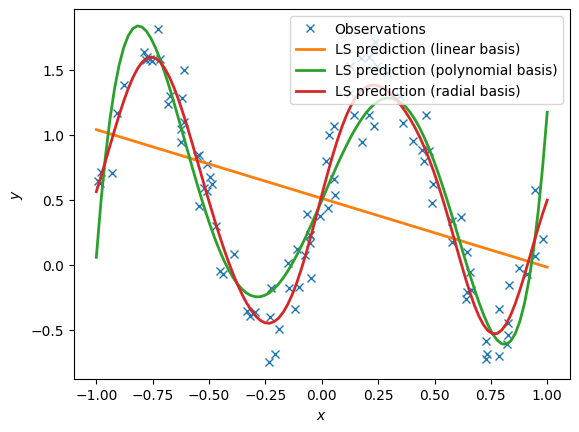

In [3]:
from linear_regression import design_matrix, LinearBasis, RadialBasisFunctions, PolynomialBasis

# generate some sample data
N_samples = 100
sigma = 0.2
X_g = np.random.uniform(-1, 1, size=N_samples)[:, None]
Y_g = g(X_g, noise_variance=sigma**2)
X, Y = X_g, Y_g # save for later

#comparisson of different basis functions
phi_linear = LinearBasis()

poly_degree = 5
phi_poly = PolynomialBasis(degree=poly_degree) #different degrees lead to different results
#equivalent to using np.polyfit() but defining own basis fucntions gives more flexibility

# varying ...
ell = 0.2 #lengthscale
num_terms = 10
Xc = np.linspace(-1, 1, num_terms) #centers

phi_radial = RadialBasisFunctions(Xc, ell)

# evaluate design matrix for each basis function
Phi_lin = design_matrix(X, phi_linear)
Phi_pol = design_matrix(X, phi_poly)
Phi_rad = design_matrix(X, phi_radial)

# carry out the least squares fit
w_LS_lin = np.linalg.lstsq(Phi_lin, Y, rcond=None)[0]
w_LS_pol = np.linalg.lstsq(Phi_pol, Y, rcond=None)[0]
w_LS_rad = np.linalg.lstsq(Phi_rad, Y, rcond=None)[0]

# use fitted model to make predictions at 100 points
X_p = np.linspace(-1, 1, 100)[:, None]

Phi_p_lin = design_matrix(X_p, phi_linear)
Y_p_lin = Phi_p_lin @ w_LS_lin

Phi_p_pol = design_matrix(X_p, phi_poly)
Y_p_pol = Phi_p_pol @ w_LS_pol

Phi_p_rad = design_matrix(X_p, phi_radial)
Y_p_rad = Phi_p_rad @ w_LS_rad

# plotting code
plt.plot(X, Y, 'x', label='Observations')
plt.plot(X_p, Y_p_lin, lw=2, label='LS prediction (linear basis)')
plt.plot(X_p, Y_p_pol, lw=2, label='LS prediction (polynomial basis)')
plt.plot(X_p, Y_p_rad, lw=2, label='LS prediction (radial basis)')
plt.xlabel('$x$'); plt.ylabel('$y$'); plt.legend(loc='best');

Can see the different performance of the different basis functions on the noisy sinusoidal data. Can change the hyperparameters to change the performance, i.e. degree of polynomial basis functions, however using extreme values can lead to overfitting with greater errors. For example, if we look at the contributions from each basis function, as shown below, we can see that larger degree polynomials lead to extreme values at large |x|, so we are relying on different degree polynomials cancelling each other out, prone to error.

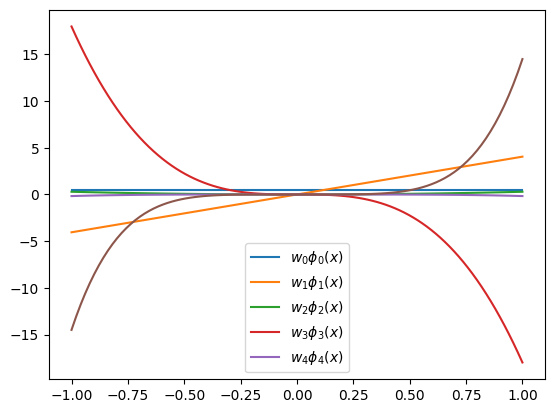

In [4]:
for i in range(phi_poly.num_basis):
    plt.plot(X_p, Phi_p_pol[:, i] * w_LS_pol[i] ,'-')
plt.legend([f'$w_{j} \phi_{j}(x)$' for j in range(poly_degree)], loc='best');

Issues with least squares: 
- How do you quantify the measurement noise?
- How many basis functions should you use?
- Which basis functions should you use?
- How do we pick the parameters of the basis functions, e.g., the lengthscale ℓ
 for the RBFs?

## Maximum Likelihood Estimation (MLE)

This probabilistic interpretation can fix some of these issues.

We model the measurement process using a likelihood function: 
$$
\mathbf{y}_{1:n} \mid \mathbf{x}_{1:n}, \mathbf{w} \sim \mathbf{P}\left(\mathbf{y}_{1:n} \mid \mathbf{x}_{1:n}, \mathbf{w}\right)
$$

this expresses how plausible the outputs are given the inputs and that we know the weights.

Assuming that the measurements are independent means that the overall probability is the product of the probabilities of a single measurement. We can also assume that the measurement is around the model prediction but with a gaussian error (likelihood can be modelled as a gaussian). Therefor the gaussian likelihood of many independant observations is 
$$
P\left(\mathbf{y}_{1:n} \mid \mathbf{x}_{1:n}, \mathbf{w}, \sigma\right) = \mathcal{N}\left(\mathbf{y}_{1:n} \mid \Phi \mathbf{w}, \sigma^2 \mathbf{I}_n\right)
$$
where $\sigma$ models the noise on the data, and $I$ is the identity.

The model can then be trained by finding the wieghts that maximise the likelihood (analytically tractable in the Gaussian case).

Can also maximise the likelihood over the noise parameter, $\sigma$, the MLE estimate can be interpreted as the standard error in the least squares prediction $\Phi w_{MLE}$ with respect to $y$, (the residuals of the fit) normalised by $\sqrt{n}$.

Predictions can then be made using laws of probability.
$$
P\left(y \mid x, \mathbf{w}_{\text{MLE}}, \sigma^2_{\text{MLE}}\right) = \mathcal{N}\left(y \, \bigg|\; \mathbf{w}_{\text{MLE}}^T \phi(x), \sigma^2_{\text{MLE}}\right)
$$


In [5]:
from linear_regression import least_squares_MLE

#example with using radial basis functions as before

w_MLE, sigma_MLE = least_squares_MLE(Phi_rad, Y, X)

Y_p = (Phi_p_rad @ w_MLE).flatten()

Y_l = Y_p - 2. * sigma_MLE # Lower predictive bound (95% confidence interval)
Y_u = Y_p + 2. * sigma_MLE # Upper predictive bound (95% confidence interval)

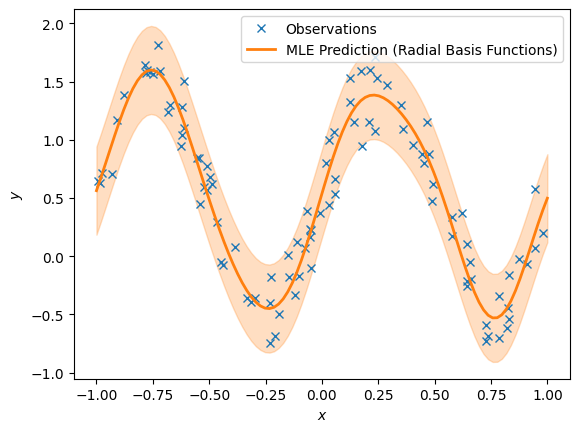

In [6]:
plt.plot(X, Y, 'x', label='Observations')
plt.plot(X_p, Y_p, lw=2, label='MLE Prediction (Radial Basis Functions)')
plt.fill_between(X_p.flatten(), Y_l, Y_u, color='C1', alpha=0.25)
plt.xlabel('$x$')
plt.ylabel('$y$')
plt.legend(loc='best');

Remaining Issues with Maximum Likelihood:
- How many basis functions should I use?
- Which basis functions should I use?
- How do I pick the parameters of the basis functions, e.g., the lengthscale 
ℓ of the RBFs?
- Uncertainty estimates don't account for extrapolation outside of range of data

## Bayesian Linear Regression

Same as previous we wish to model the data using fixed basis/features as well as modelling the measurement process using a likelihood function, however this method incorporates a prior to model the uncertainty in the model parameters.
For example the following gaussian prior:
$$
P\left(\mathbf{w} \mid \alpha\right) = \mathcal{N}\left(\mathbf{w} \mid \mathbf{0}, \alpha^{-1} \mathbf{I}\right) = \left(\frac{\alpha}{2\pi}\right)^{\frac{m}{2}} \exp\left\{-\frac{\alpha}{2} \mathbf{w}^\top \mathbf{w}\right\}
$$

can be interpreted as, before we see the data we expect $w$ to be around zero with a precision of $\alpha$, where precision is $\frac{1}{\sigma^{2}}$